In [1]:
import numpy as np
import sympy as sp
import pickle
from joblib import Parallel, delayed
from tqdm import tqdm
import os
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from functions.simulation_functions import param_scan
import nbimporter
from theory import manual_mu_n, manual_v_n, rec_mean, rec_var

In [3]:
# run a paramater scan across p and q values
ics_mu     = np.array([1, 0])           # start with one sensitive cell and zero resistant cells
ics_var    = np.array([0, 0, 0])        # since we have a deterministic initial population, the variance is 0
num_gens   = 30                         # simulate for 10 generations
num_trials = 10000                      # run 10,000 trials for each parameter pair

p_vals = np.arange(0, 1.0500, 0.050)   # vary p from 0 to 1 with 0.05 increments
q_vals = np.arange(0, 1.0500, 0.050)   # vary p from 0 to 1 with 0.05 increments

sim_data = param_scan(ics_mu, num_gens, num_trials, p_vals, q_vals) # index using `sim_data[p_idx, q_idx, trial#, gen#, cell_type]`

Simulating (p, q) pairs: 100%|██████████| 441/441 [00:53<00:00,  8.18it/s]


In [4]:
# open theory expressions for µ_n and v_n:
theory_dir = './thr_output'
with open(os.path.join(theory_dir, 'mu_n.pkl'), 'rb') as file:
    mu_n = pickle.load(file)
with open(os.path.join(theory_dir, 'v_n.pkl'), 'rb') as file:
    v_n  = pickle.load(file)

# p, q: real numbers in [0, 1]
p = sp.Symbol('p', real=True, nonnegative=True)    # probability of becoming resistant from sensitive
q = sp.Symbol('q', real=True, nonnegative=True)    # probability of becoming sensitive from resistant

# n: integer
n = sp.Symbol('n', integer=True, nonnegative=True) # number of generations

# initial conditions for mean, µ0_1, µ0_2: real numbers
mu_0_S = sp.Symbol('\mu_0^{(S)}', real=True, nonnegative=True)
mu_0_R = sp.Symbol('\mu_0^{(R)}', real=True, nonnegative=True)
mu_0   = sp.Matrix([[mu_0_S], [mu_0_R]])

# initial conditions for variance, v0_1, v0_2, v0_3: real numbers
v_0_S  = sp.Symbol('v_0^{(S)}', real=True, nonnegative=True)
v_0_SR = sp.Symbol('v_0^{(SR)}', real=True, nonnegative=True)
v_0_R  = sp.Symbol('v_0^{(R)}', real=True, nonnegative=True)
v_0    = sp.Matrix([[v_0_S], [v_0_SR], [v_0_R]])

# convert the symbolic expressions into numerical expressions
# which are faster to compute
mu_n_num = sp.lambdify([p, q, n, mu_0_S, mu_0_R], mu_n)
v_n_num  = sp.lambdify([p, q, n, mu_0_S, mu_0_R, v_0_S, v_0_SR, v_0_R], v_n)

In [15]:
warnings.filterwarnings("ignore", category=RuntimeWarning) # ignore divide by 0 warnings

# calculate the theoretical mean and variances for the simulated parameter sets
thr_data = np.zeros((len(p_vals), len(q_vals), 2, num_gens+1, 2)) # index using `thr_data[p_idx, q_idx, {0: mean, 1: var}, gen#, cell_type]`

# define a small error threshold
epsilon = 1e-15

# computation for one set (p_val, q_val, n_val)
for i, p_val in enumerate(tqdm(p_vals)):
    for j, q_val in enumerate(q_vals):
        for n_val in range(num_gens+1):

            if (abs(p_val + q_val) < epsilon) or (abs(p_val + q_val - 1) < epsilon):
                mean = rec_mean(p_val, q_val, n_val, ics_mu)
                var  = rec_var(p_val, q_val, n_val, ics_mu, ics_var)
            else:
                mean = mu_n_num(p_val, q_val, n_val, ics_mu[0], ics_mu[1])
                var = v_n_num(p_val, q_val, n_val, ics_mu[0], ics_mu[1], ics_var[0], ics_var[1], ics_var[2])

            thr_data[i, j, 0, n_val, :] = mean.flatten()
            thr_data[i, j, 1, n_val, :] = var[[0,2]].flatten()

100%|██████████| 21/21 [00:02<00:00,  7.69it/s]


In [16]:
# 1a) compare the simulated and theoretical mean and variances

sim_mean = np.mean(sim_data[:, :, :, num_gens, 1], axis=2)
thr_mean = thr_data[:, :, 0, num_gens, 1]

sim_var  = np.var(sim_data[:, :, :, num_gens, 1], axis=2)
thr_var  = thr_data[:, :, 1, num_gens, 1]

# calculate the absolute and relative error between the means
# if both thr_var and sim_var == 0, set rel_error = 0
# if thr_var == 0 but sim_var != 0, set rel_error = np.nan
mean_abs_error = np.abs(sim_mean - thr_mean)
mean_rel_error = np.where(
    (thr_mean == 0) & (sim_mean == 0), 0.0,
    np.abs(sim_mean - thr_mean) / np.where(thr_mean == 0, np.nan, thr_mean)
)
mean_rel_error *= 100

# calculate the absolute and relative errors between the variances
var_abs_error = np.abs(sim_var - thr_var)
var_rel_error = np.where(
    (thr_var == 0) & (sim_var == 0), 0.0,
    np.abs(sim_var - thr_var) / np.where(thr_var == 0, np.nan, thr_var)
)
var_rel_error *=100

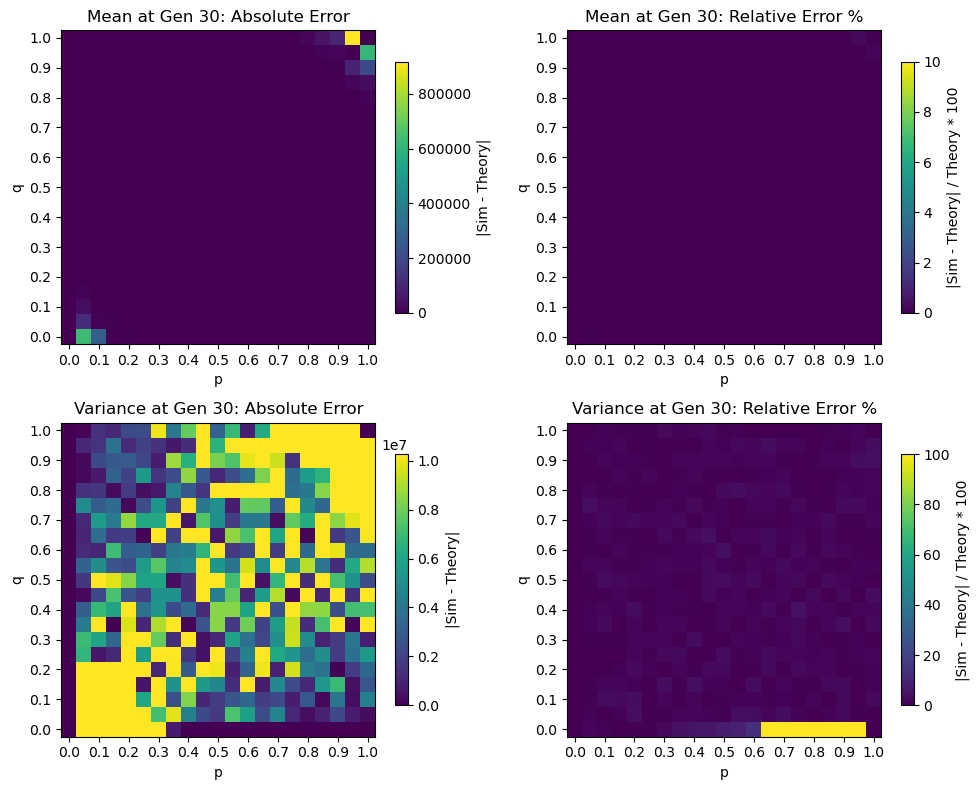

In [17]:
# 1b) visualize error results with a heatmap
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

im00 = axs[0, 0].imshow(mean_abs_error.T, origin='lower', vmin=0)
axs[0, 0].set_title(f'Mean at Gen {num_gens}: Absolute Error')
fig.colorbar(im00, ax=axs[0, 0], label='|Sim - Theory|', shrink=0.8)

im01 = axs[0, 1].imshow(mean_rel_error.T, origin='lower', vmin=0, vmax=10)
axs[0, 1].set_title(f'Mean at Gen {num_gens}: Relative Error %')
fig.colorbar(im01, ax=axs[0, 1], label='|Sim - Theory| / Theory * 100', shrink=0.8)

im10 = axs[1, 0].imshow(var_abs_error.T, origin='lower', vmin=0, vmax=np.percentile(var_abs_error[~np.isnan(var_abs_error)], 75))
axs[1, 0].set_title(f'Variance at Gen {num_gens}: Absolute Error')
fig.colorbar(im10, ax=axs[1, 0], label='|Sim - Theory|', shrink=0.8)

im11 = axs[1, 1].imshow(var_rel_error.T, origin='lower', vmin=0)
axs[1, 1].set_title(f'Variance at Gen {num_gens}: Relative Error %')
fig.colorbar(im11, ax=axs[1, 1], label='|Sim - Theory| / Theory * 100', shrink=0.8)

for i in range(2):
    for j in range(2):
        axs[i, j].set_xticks(np.arange(len(p_vals))[::2])
        axs[i, j].set_xticklabels(np.round(p_vals[::2], 2))
        axs[i, j].set_xlabel('p')

        axs[i, j].set_yticks(np.arange(len(q_vals))[::2])
        axs[i, j].set_yticklabels(np.round(q_vals[::2], 2))
        axs[i, j].set_ylabel('q')

plt.tight_layout()
plt.show()